In [286]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from scipy.io import loadmat
import scipy.signal as sp
import scipy.optimize as op
import nanosphere_utils as ns
import importlib

In [331]:
data_path = '/Users/dcmoore/Desktop/nanosphere_data' #"/Volumes/DATA/nanosphere_data"

data_folders = ['20240724_minus_one_e_data/20240724_50v_1_8e-8mbar',]

In [332]:
combined_path = os.path.join(data_path, data_folders[0], '**/*.mat')
data_files = glob.glob(combined_path, recursive=True)

In [333]:
print(data_files)

['/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_4.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005

In [417]:
importlib.reload(ns)

filt_band = [25e3, 200e3]
wind_size = 1e-3 ## fitting window in seconds
omega0 = 2*np.pi*64.5e3 ## resonant frequency guess

fit_amps = []

for data_file in data_files:
    data = loadmat(data_file)

    sphere_z = np.ndarray.flatten(data['D'])
    drive = np.ndarray.flatten(data['G'])
    tstep = data['Tinterval'][0]
    time = np.arange(0, len(sphere_z)*tstep, tstep)

    filtered_data = ns.get_filtered_data(time, sphere_z, drive, filt_band, tstep, make_plot=False) 
    ns.get_psd(sphere_z, tstep, filtered_data = filtered_data, make_plot = False)

    ## now find the impulses and step through each one, plotting and fitting
    impulse_idxs = ns.find_impulses(drive, make_plot=False)

    for idx in impulse_idxs:

        print("Working on impulse at time: ", time[idx])    

        curr_window = [time[idx]-wind_size, time[idx]+wind_size]

        
        #amp, fail_flag = ns.fit_data_impulse(time, filtered_data, curr_window, p0_guess=[], drive=drive, make_plot=True, plot_guess=False)
        amp, amp_lp, f0, gamma = ns.deconvolve_force_amp(time, filtered_data, curr_window, lp_freq=100e3, make_plot=False)

        fit_amps.append([amp, amp_lp, f0, gamma])

fit_amps = np.array(fit_amps)

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_30469/359274140.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time = np.arange(0, len(sphere_z)*tstep, tstep)


Working on impulse at time:  0.2698330031532947
Working on impulse at time:  0.5698302066590912
Working on impulse at time:  0.8698274101648877
Working on impulse at time:  1.169824413670682
Working on impulse at time:  1.4698216171764784
Working on impulse at time:  1.769818820682275
Working on impulse at time:  0.06537820076401601
Working on impulse at time:  0.3653754042698125
Working on impulse at time:  0.665372607775609
Working on impulse at time:  0.9653696112814032
Working on impulse at time:  1.2653668147871997
Working on impulse at time:  1.5653640182929962
Working on impulse at time:  1.8653612217987927
Working on impulse at time:  0.19835760231802624
Working on impulse at time:  0.49835480582382274
Working on impulse at time:  0.7983520093296192
Working on impulse at time:  1.0983492128354158
Working on impulse at time:  1.39834621634121
Working on impulse at time:  1.6983434198470064
Working on impulse at time:  1.998340623352803
Working on impulse at time:  0.124535401455

In [418]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

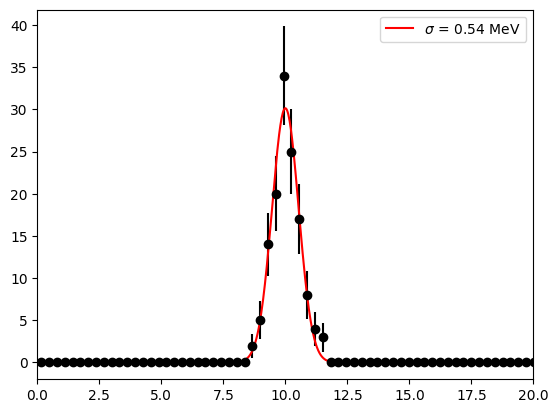

In [420]:
bins = np.linspace(0, 0.07, 80)
hh, be = np.histogram(np.abs(fit_amps[:,1]), bins=bins)
bc = 0.5*(be[1:]+be[:-1])

gp, gcov = op.curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(bc), np.std(bc)])

cal_fac = 10.0/gp[1]

xx = np.linspace(0,0.07,1000)

plt.figure()
plt.errorbar(bc*cal_fac, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(xx*cal_fac, gauss(xx, *gp), 'r', label="$\sigma$ = %.2f MeV" % (gp[2]*cal_fac))
plt.xlim(0,20)
plt.legend()
plt.show()
